# CarGuardians: Master Analysis Pipeline & Report

## 1. Executive Summary
**Objective:** Predict Air Pressure System (APS) failures in Scania trucks to minimize maintenance costs.
**Key Challenge:** The cost of a missed failure (False Negative) is 50x higher than an unnecessary check (False Positive).
**Methodology:** 
1.  **Cost-Sensitive Learning:** LightGBM with custom objective functions.
2.  **Advanced Causal Modeling:** Sparse Bayesian Networks (PyMC) to identify root causes.
3.  **The Grand Unification:** A consensus approach combining K-S Tests, SHAP values, and Lasso Regression to find the true drivers of failure.

## 2. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Project Imports
from challenge.data.ingest import load_data
from challenge.data.feature_selection import (
    select_features_ks, 
    select_features_mutual_info, 
    create_engineered_feature_set
)
from challenge.modelling.train_eval import evaluate_on_test
from challenge.modelling.experiment import run_experiment_grid
from challenge.modelling.models import get_models
from challenge.visualization.performance_viz import plot_experiment_results, plot_confusion, plot_cost_threshold_curve

# Visualization & Analysis Imports
from challenge.visualization.eda_plots import eda_plots_with_stats
from challenge.analysis.pca_analysis import pca_inspect, inspect_pca_loadings
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.data.preprocess import ScaniaPreprocessor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")

DATA_PATH = 'dataset/'
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'

python(67608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## 3. Data Ingestion & Initial Cleaning
We load the raw data and perform minimal cleaning (dropping low-NA rows and known outliers).

In [2]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

# Initial Cleaning: Drop rows with missing values in low-NA columns
na_pct = X_train_raw.isna().mean()
low_na_cols = na_pct[(na_pct > 0) & (na_pct <= 0.04)].index

if not low_na_cols.empty:
    rows_to_drop = X_train_raw[low_na_cols].isna().any(axis=1)
    drop_indices = X_train_raw[rows_to_drop].index
    
    X_train_raw = X_train_raw.drop(index=drop_indices)
    y_train_raw = y_train_raw.drop(index=drop_indices)
    print(f"Dropped {len(drop_indices)} rows based on low-NA columns.")

# Specific Outlier Removal (Identified via PCA)
# This observation has Z-scores > 100 on multiple features, indicating sensor error
outlier_idx_to_drop = 20683
if outlier_idx_to_drop in X_train_raw.index:
    print(f"Dropping known outlier at index {outlier_idx_to_drop}")
    X_train_raw = X_train_raw.drop(index=outlier_idx_to_drop)
    y_train_raw = y_train_raw.drop(index=outlier_idx_to_drop)

print(f"Cleaned train shape: {X_train_raw.shape}")

Successfully loaded and processed aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)
Dropped 1873 rows based on low-NA columns.
Dropping known outlier at index 20683
Cleaned train shape: (58126, 170)


## 4. Advanced Exploratory Data Analysis (EDA)
**Methodology:** We use PCA to identify global outliers and Mutual Information to focus our visual inspection on the most relevant features.

**Interpretation:**
*   **PCA:** Helps spot extreme sensor errors (like row 20683).
*   **Correlation:** Reveals clusters of redundant sensors (e.g., `ag_000` family).
*   **Distributions:** Shows the massive skew in sensor readings (mostly zero for healthy trucks).

Preparing data for visualization...


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31039e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31041e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31038e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.3103e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.67209e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/

Scaling data...
Selecting top 50 features via K-S for EDA...
Starting K-S test on 162 features...

--- PCA Analysis (Top 50 Features) ---
Explained variance ratio: 0.751


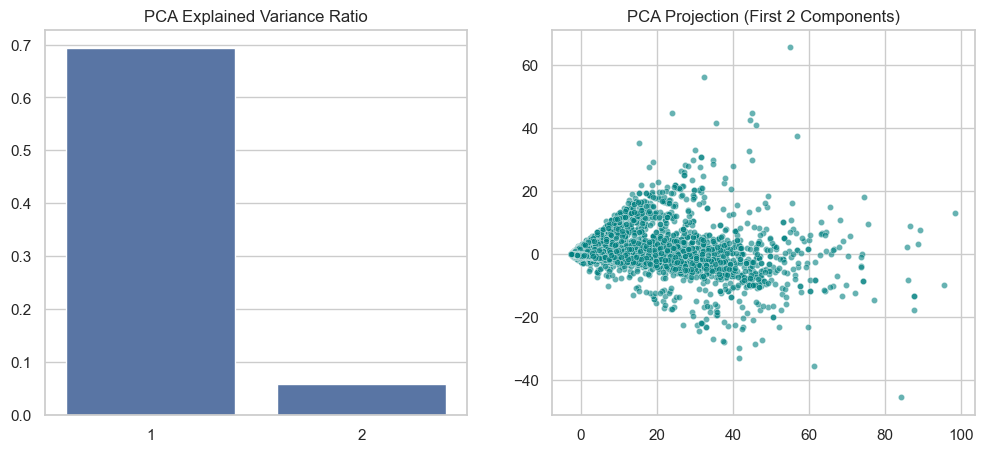


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 54392
Original Index Label: 56153
PC1 Value: 98.45
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
ee_003    31.957787
bi_000    28.128954
ba_001    27.427206
cn_003    26.412222
ee_004    24.690409
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


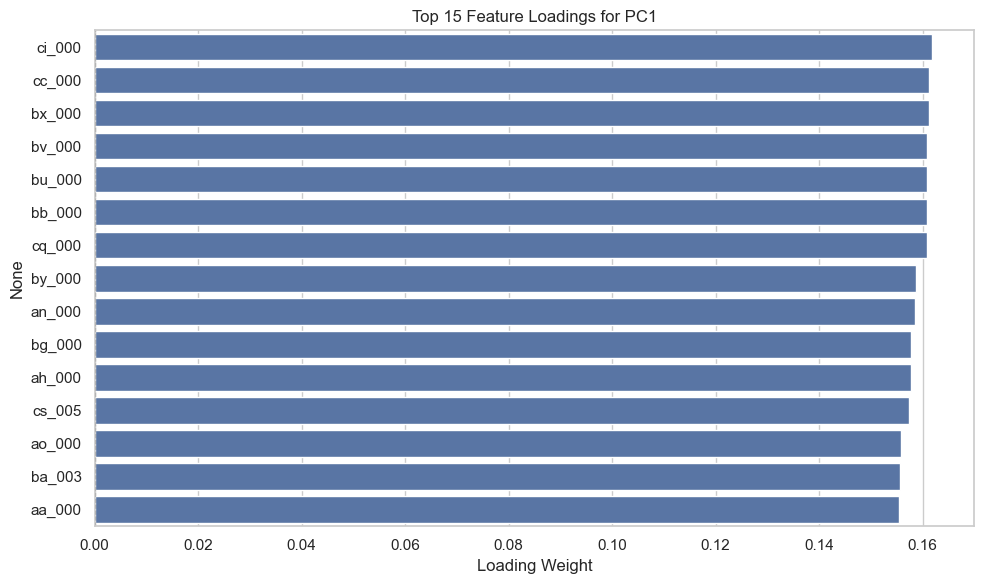


--- Correlation Heatmap (Top 50 Features) ---


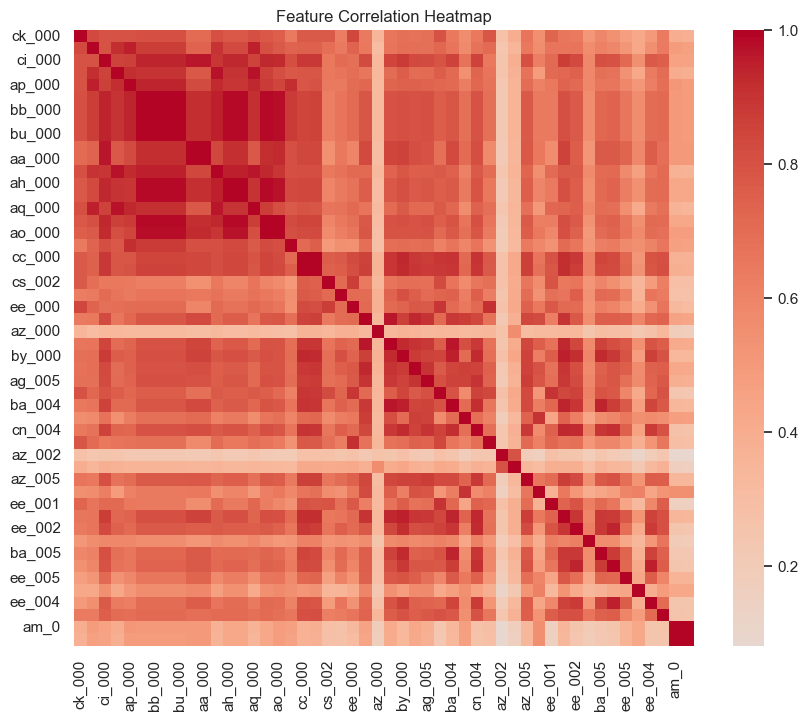


--- Feature Distributions (Top 3 Selected Features) ---
Feature 'ck_000', Class 1 → Mean: 8452585.2779, Std: 6518341.7733
Feature 'ck_000', Class 0 → Mean: 580426.6594, Std: 1733614.4921


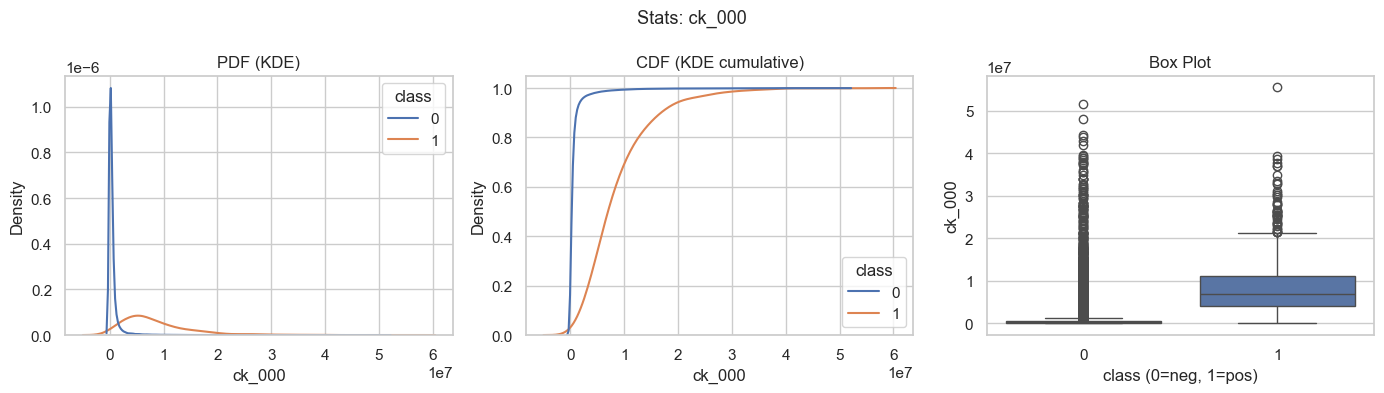

****************************************************************************************************
Feature 'bj_000', Class 1 → Mean: 7857091.0161, Std: 6820064.2473
Feature 'bj_000', Class 0 → Mean: 384869.4594, Std: 1279047.6474


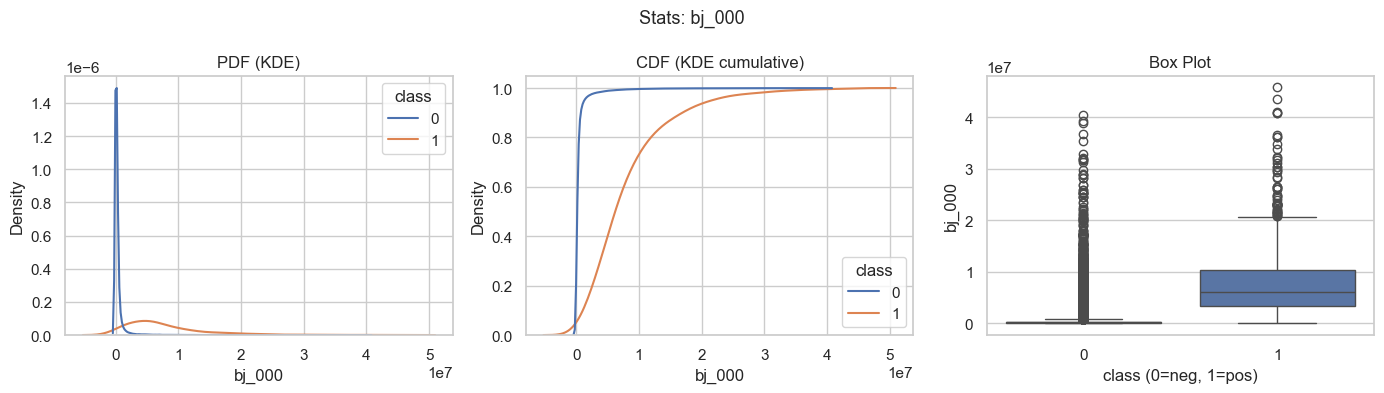

****************************************************************************************************
Feature 'ci_000', Class 1 → Mean: 38989309.8623, Std: 23811706.3385
Feature 'ci_000', Class 0 → Mean: 2883076.8585, Std: 6300749.3423


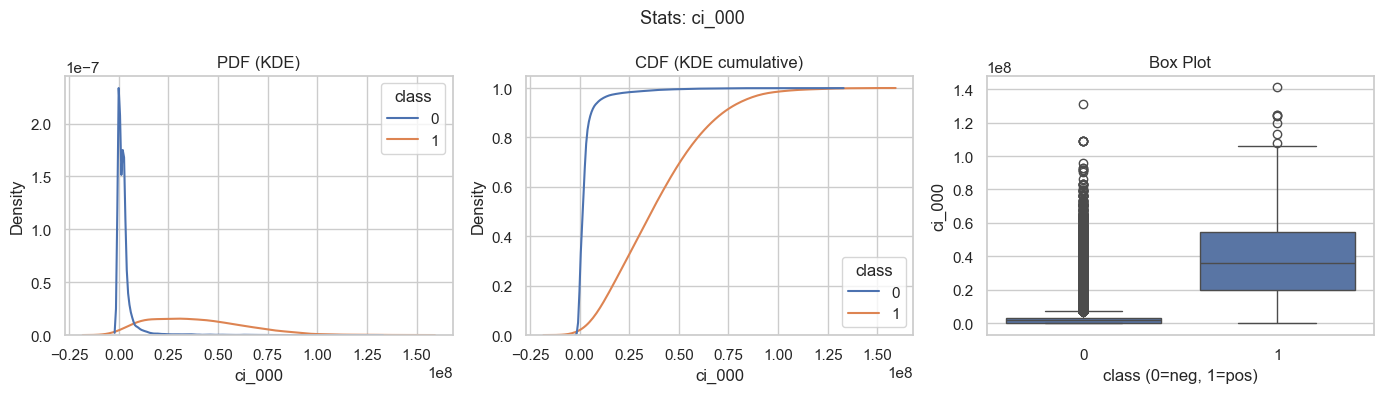

****************************************************************************************************


In [3]:
from sklearn.preprocessing import StandardScaler

# Quick imputation for visualization purposes (using the project's preprocessor)
print("Preparing data for visualization...")
preproc_viz = ScaniaPreprocessor()
X_clean = preproc_viz.fit_transform(X_train_raw)

# Scale the data (Critical for PCA)
print("Scaling data...")
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_clean)
X_viz = pd.DataFrame(X_scaled_np, columns=X_clean.columns, index=X_clean.index)

# --- Feature Selection for EDA ---
# Select top 50 features using Mutual Information for focused analysis
# We use X_viz (preprocessed & scaled) to ensure we only select features that were not dropped
print("Selecting top 50 features via K-S for EDA...")
top_features_eda = select_features_ks(X_viz, y_train_raw, p_value_threshold=0.05, top_n_by_stat=50)
X_viz_selected = X_viz[top_features_eda]

# 1. PCA Analysis (on selected features)
print(f"\n--- PCA Analysis (Top {len(top_features_eda)} Features) ---")
pca_df = pca_inspect(X_viz_selected)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_selected.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_selected.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_selected, component_idx=0)

# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {len(top_features_eda)} Features) ---")
plot_correlation_heatmap(X_viz_selected) 

# 3. Feature Distributions (EDA with Stats)
print(f"\n--- Feature Distributions (Top 3 Selected Features) ---")
# Combine X and y temporarily for plotting
# Note: We use X_train_raw for the stats plot to show original values, not scaled ones
df_viz = X_train_raw[top_features_eda].copy()
df_viz['class'] = y_train_raw

# Visualize the top 3 features from the selection
eda_plots_with_stats(df_viz[top_features_eda[:3] + ['class']], title_prefix="Stats: ")

## 5. Feature Engineering & Selection Strategy
We compare three distinct feature sets to test different hypotheses:
1. **K-S Selected:** Features with the largest distribution shift between Healthy and Failed (Univariate).
2. **Mutual Information:** Features with the highest non-linear dependency with the target.
3. **Engineered:** Statistical moments replacing raw histogram bins.

In [4]:
# 1. K-S Selection
print("--- Computing K-S Feature Set ---")
selected_features_ks = select_features_ks(X_train_raw, y_train_raw, top_n_by_stat=100, p_value_threshold=0.05)
X_train_ks = X_train_raw[selected_features_ks]
X_test_ks = X_test_raw[selected_features_ks]
print(f"K-S Train Shape: {X_train_ks.shape}")

# 2. Mutual Information Selection
print("\n--- Computing Mutual Information Feature Set ---")
selected_features_mi = select_features_mutual_info(X_train_raw, y_train_raw, top_n=100)
X_train_mi = X_train_raw[selected_features_mi]
X_test_mi = X_test_raw[selected_features_mi]
print(f"MI Train Shape: {X_train_mi.shape}")

# 3. Feature Engineering
print("\n--- Computing Engineered Feature Set ---")
X_train_eng = create_engineered_feature_set(X_train_raw)
X_test_eng = create_engineered_feature_set(X_test_raw)
print(f"Engineered Train Shape: {X_train_eng.shape}")

--- Computing K-S Feature Set ---
Starting K-S test on 170 features...
K-S Train Shape: (58126, 100)

--- Computing Mutual Information Feature Set ---
Calculating Mutual Information...
Selected top 100 features by Mutual Information.
MI Train Shape: (58126, 100)

--- Computing Engineered Feature Set ---
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135
Engineered Train Shape: (58126, 135)


In [ ]:
# Check how many features are selected by K-S and Mutual Information and how many overlap
print(f"K-S Selected Features: {len(selected_features_ks)}")
print(f"Mutual Information Selected Features: {len(selected_features_mi)}")
print(f"Overlap: {len(set(selected_features_ks).intersection(set(selected_features_mi)))}")

# Select the set of features that are selected by K-S + Mutual Information (we use set to handle overlapped features)
selected_features = list(set(selected_features_ks).union(set(selected_features_mi)))

# Select the features from the training and test sets
X_train_ks_mi = X_train_raw[selected_features]
X_test_ks_mi = X_test_raw[selected_features]
print(f"K-S + MI Train Shape: {X_train_ks_mi.shape}")


K-S Selected Features: 100
Mutual Information Selected Features: 100
Overlap: 89
K-S + MI Train Shape: (58126, 111)


## 6. Model Experimentation Grid
We run a comprehensive grid search over Models, Feature Sets, and Sampling Strategies.
**Metric:** Total Cost (FP=10, FN=500).

In [6]:
# Define Feature Sets
FEATURE_SETS = {
    "K-S Selected": (X_train_ks, X_test_ks),
    "Mutual Information": (X_train_mi, X_test_mi),
    "K-S + MI": (X_train_ks_mi, X_test_ks_mi),
    # "Engineered": (X_train_eng, X_test_eng) # Uncomment to include (slower)
}

# Define Models
MODELS = get_models(random_state=42)

# Define Samplers
SAMPLERS = {
    "No Sampling": None,
    "SMOTE": "smote",
    "Gaussian Copula": "copula" # Uncomment to include
}

# Define Sampling Percentages
SAMPLING_PCTS = [0.25, 0.5]

# Define Tuning Strategies
TUNING = {
    "Tuned Threshold": True,
    # "Fixed 0.5": False
}

# Run the Grid
results_df = run_experiment_grid(
    models=MODELS,
    feature_sets=FEATURE_SETS,
    samplers=SAMPLERS,
    tuning_strategies=TUNING,
    sampling_percentages=SAMPLING_PCTS,
    y_train=y_train_raw,
    n_cv_splits=5, # Reduced for speed in demo
    verbose=True
)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM | K-S Selected | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


python(67649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/p

AUC 0.988±0.005 | Macro-F1 0.727 | Cost 7024±665 | thr(median) 0.003076173088229483 | fit 8.97s | pred 0.35s

RUNNING: LightGBM | K-S Selected | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.989±0.005 | Macro-F1 0.758 | Cost 6910±710 | thr(median) 0.026990430341806 | fit 4.77s | pred 0.03s

RUNNING: LightGBM | K-S Selected | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.729 | Cost 7474±952 | thr(median) 0.02074317074112377 | fit 7.98s | pred 0.03s

RUNNING: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57197
AUC 0.988±0.005 | Macro-F1 0.739 | Cost 6962±1289 | thr(median) 0.007741925573192631 | fit 13.03s | pred 0.01s

RUNNING: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
AUC 0.989±0.005 | Macro-F1 0.737 | Cost 6632±1311 | thr(median) 0.01091945090283531 | fit 18.15s | pred 0.14s

RUNNING: LightGBM | Mutual Information | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.777 | Cost 7188±753 | thr(median) 0.006401253429846679 | fit 7.71s | pred 0.10s

RUNNING: LightGBM | Mutual Information | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.743 | Cost 7028±826 | thr(median) 0.026306715618856728 | fit 9.57s | pred 0.13s

RUNNING: LightGBM | Mutual Information | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.744 | Cost 7526±1168 | thr(median) 0.033706824465151095 | fit 8.61s | pred 0.07s

RUNNING: LightGBM | Mutual Information | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving th

Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
AUC 0.989±0.005 | Macro-F1 0.745 | Cost 6934±1089 | thr(median) 0.010191920204077973 | fit 12.45s | pred 0.02s

RUNNING: LightGBM | Mutual Information | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68635
AUC 0.987±0.006 | Macro-F1 0.738 | Cost 7072±1453 | thr(median) 0.01163406164534202 | fit 13.70s | pred 0.02s

RUNNING: LightGBM | K-S + MI | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.759 | Cost 7078±657 | thr(median) 0.004549403595440398 | fit 10.40s | pred 0.06s

RUNNING: LightGBM | K-S + MI | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.989±0.005 | Macro-F1 0.736 | Cost 6914±732 | thr(median) 0.016172983909844736 | fit 10.08s | pred 0.02s

RUNNING: LightGBM | K-S + MI | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.004 | Macro-F1 0.743 | Cost 7046±1287 | thr(median) 0.0291885126760243 | fit 9.72s | pred 0.02s

RUNNING: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We stron

Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
AUC 0.988±0.005 | Macro-F1 0.720 | Cost 6696±867 | thr(median) 0.008329277436782143 | fit 16.49s | pred 0.02s

RUNNING: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...
Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
AUC 0.988±0.005 | Macro-F1 0.722 | Cost 6988±880 | thr(median) 0.008401211124133176 | fit 18.47s | pred 0.03s

--- EXPERIMENT MATRIX COMPLETE ---


## 7. Experiment Results & Best Model Selection

,model,feature_set,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage
4,LightGBM,K-S Selected,Gaussian Copula,Tuned Threshold,6632.0,1310.731094,0.988578,0.737201,18.145634,LightGBM | K-S Selected | Gaussian Copula | Tu...,0.50
13,LightGBM,K-S + MI,Gaussian Copula,Tuned Threshold,6696.0,867.446828,0.987886,0.719918,16.491676,LightGBM | K-S + MI | Gaussian Copula | Tuned ...,0.25
1,LightGBM,K-S Selected,SMOTE,Tuned Threshold,6910.0,709.845054,0.989081,0.758213,4.770180,LightGBM | K-S Selected | SMOTE | Tuned Thresh...,0.25
11,LightGBM,K-S + MI,SMOTE,Tuned Threshold,6914.0,731.699392,0.988961,0.735532,10.076945,LightGBM | K-S + MI | SMOTE | Tuned Threshold ...,0.25
8,LightGBM,Mutual Information,Gaussian Copula,Tuned Threshold,6934.0,1089.175835,0.988572,0.745176,12.453468,LightGBM | Mutual Information | Gaussian Copul...,0.25
3,LightGBM,K-S Selected,Gaussian Copula,Tuned Threshold,6962.0,1289.486720,0.988329,0.738597,13.030184,LightGBM | K-S Selected | Gaussian Copula | Tu...,0.25
14,LightGBM,K-S + MI,Gaussian Copula,Tuned Threshold,6988.0,880.349930,0.988332,0.721845,18.474021,LightGBM | K-S + MI | Gaussian Copula | Tuned ...,0.50
0,LightGBM,K-S Selected,No Sampling,Tuned Threshold,7024.0,664.788688,0.987872,0.727396,8.966077,LightGBM | K-S Selected | No Sampling | Tuned ...,NaN
6,LightGBM,Mutual Information,SMOTE,Tuned Threshold,7028.0,825.624612,0.988347,0.742671,9.565929,LightGBM | Mutual Information | SMOTE | Tuned ...,0.25
12,LightGBM,K-S + MI,SMOTE,Tuned Threshold,7046.0,1287.301053,0.987925,0.742682,9.720784,LightGBM | K-S + MI | SMOTE | Tuned Threshold ...,0.50


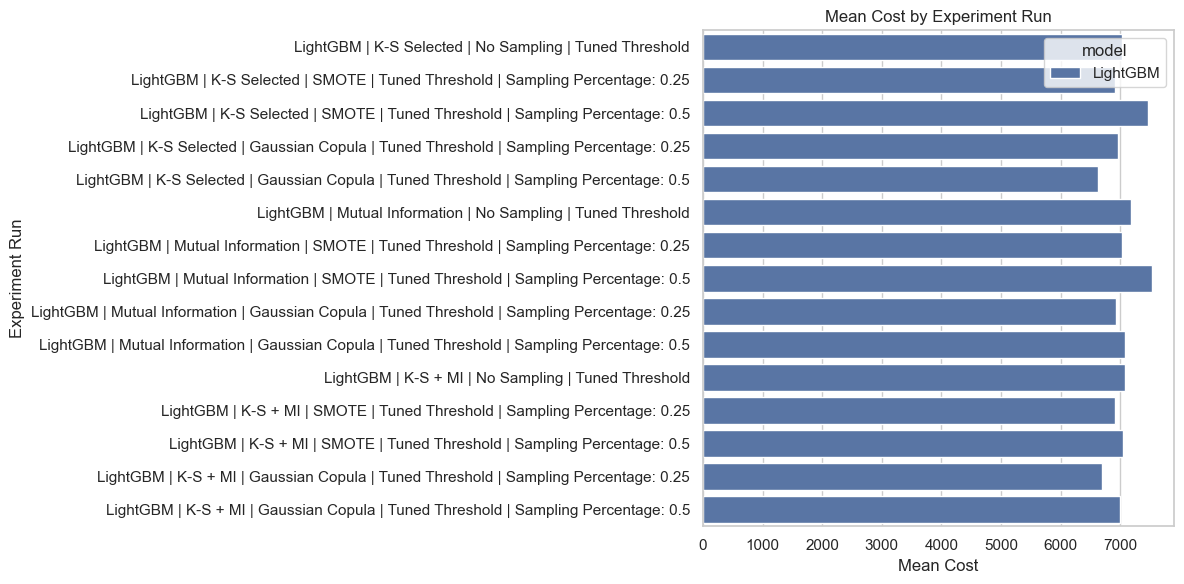

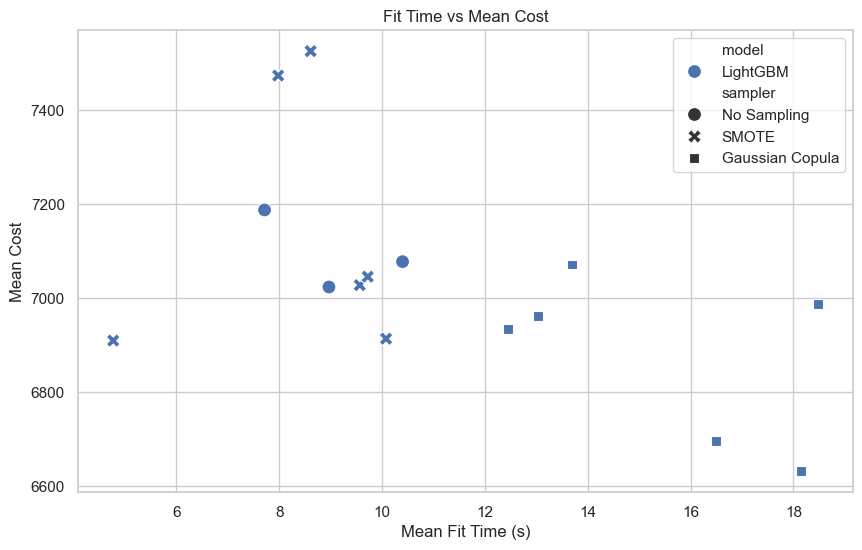

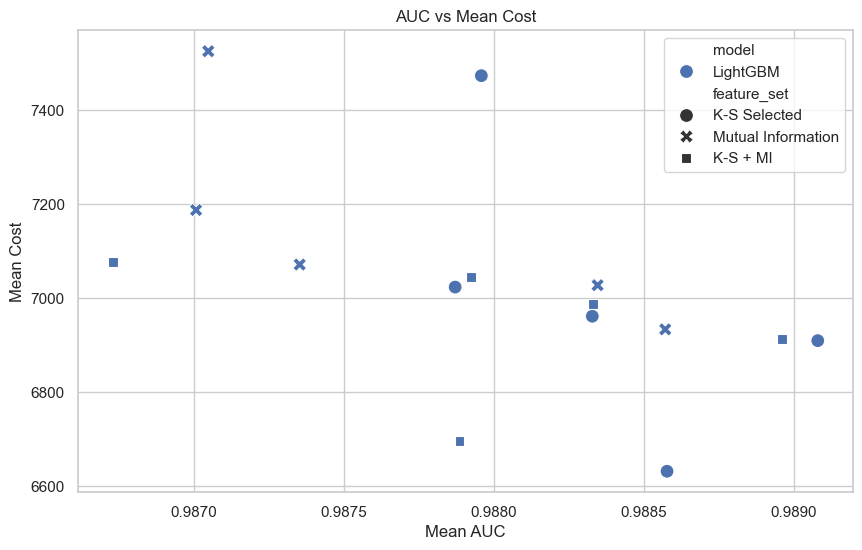

In [17]:
# Display Top Results
display(results_df.sort_values(by='cost_mean').head(10))

# Visualize Results
plot_experiment_results(results_df)

No: 1 Run: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...
Balancing complete. New dataset size: 68635


python(67937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Threshold tuned in 9.46s -> thr=0.007 (Val Cost=6390)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Balancing: 929 minority, 57197 majority.
Target ratio: 0.5 -> Target minority count: 28598
Synthesizing 27669 samples...
Balancing complete. New dataset size: 85795
Test → AUC=0.995 | F1=0.761 | Cost=10570 | Recall=0.976 | Precision=0.376 | fit=12.27s | pred=0.03s | thr=0.007
Test CM (thr=0.007): FP=607, FN=9


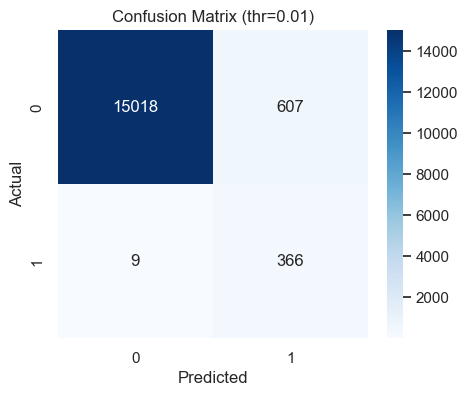

No: 2 Run: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing complete. New dataset size: 57196
Threshold tuned in 9.07s -> thr=0.014 (Val Cost=5210)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Balancing: 929 minority, 57197 majority.
Target ratio: 0.25 -> Target minority count: 14299
Synthesizing 13370 samples...
Balancing complete. New dataset size: 71496
Test → AUC=0.996 | F1=0.816 | Cost=10360 | Recall=0.965 | Precision=0.484 | fit=9.43s | pred=0.01s | thr=0.014
Test CM (thr=0.014): FP=386, FN=13


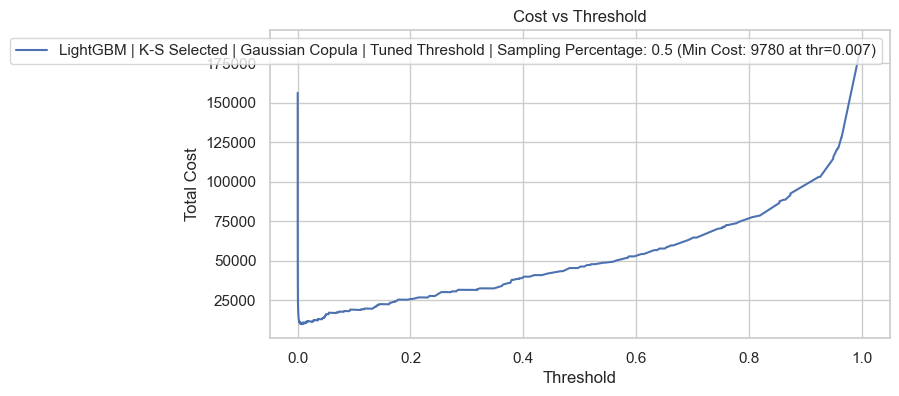

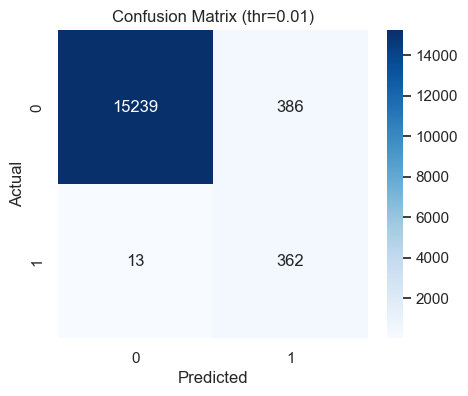

No: 3 Run: LightGBM | K-S Selected | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Threshold tuned in 3.58s -> thr=0.010 (Val Cost=5750)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with smote...
Test → AUC=0.994 | F1=0.748 | Cost=10740 | Recall=0.979 | Precision=0.353 | fit=3.25s | pred=0.02s | thr=0.010
Test CM (thr=0.010): FP=674, FN=8


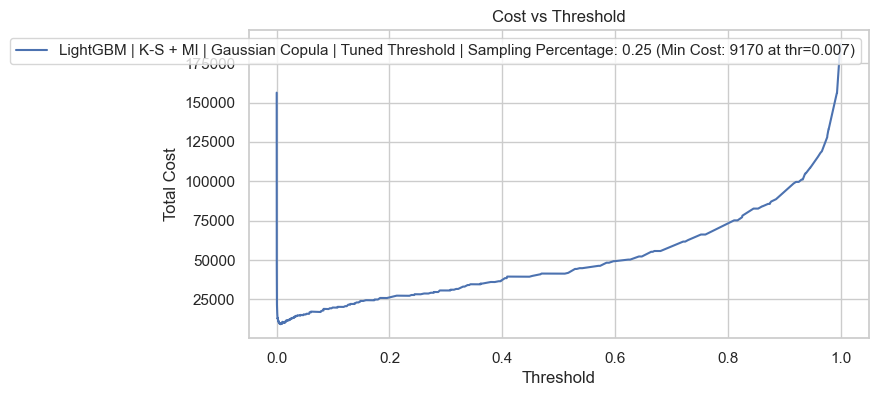

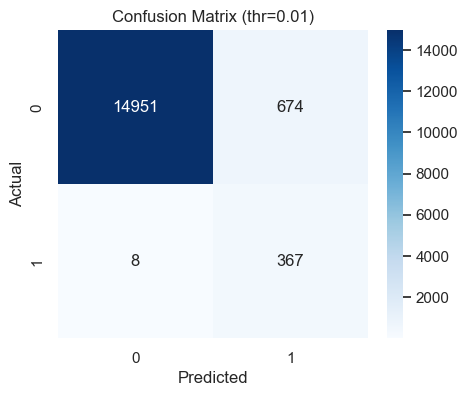

In [8]:
for i in range(3):
    if not results_df.empty:
        best_run = results_df.sort_values(by='cost_mean').iloc[i]
        print(f"No: {i+1} Run: {best_run['run_name']}")
        
        # Reconstruct the best configuration
        best_model_name = best_run['model']
        best_fset_name = best_run['feature_set']
        best_sampler_name = best_run['sampler']
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        # Get Data
        X_tr_best, X_te_best = FEATURE_SETS[best_fset_name]
        
        # Get Model
        model = MODELS[best_model_name]
        
        # Get Sampler Key
        sampler_key = SAMPLERS[best_sampler_name]
        
        # Evaluate on Test
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr_best,
            y_train=y_train_raw,
            X_test=X_te_best,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=True
        )
        
        # Plot Deep Dive Visuals
        probs = test_results['test_probabilities']
        plot_confusion(y_test_raw, probs, threshold=test_results['metrics']['Threshold'])
        plot_cost_threshold_curve(y_test_raw, probs, label=best_run['run_name'])

## 8. Root Cause Analysis (RCA): The Grand Unification

**Objective:** Determine the true causal drivers of failure.
**Method:** We combine three perspectives (excluding MI due to stability issues):
1.  **K-S Test:** Distribution Shift (General Health).
2.  **SHAP:** Interaction Effects (Complex Failure Modes).
3.  **Lasso (L1):** Linear Separability (Deterministic Triggers).

We feed the union of these top features into a **Sparse Causal Bayesian Network (PyMC)** with Laplace priors to find the survivors.

In [43]:
# RCA Imports
import dice_ml
import pymc as pm
import arviz as az
import time
import shap
from scipy.stats import ks_2samp
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import networkx as nx

# Preprocess (Impute) for RCA
print("Preprocessing for RCA...")
preprocessor = ScaniaPreprocessor()
X_train_clean = preprocessor.fit_transform(X_train_raw)
X_test_clean = preprocessor.transform(X_test_raw)

# --- 1. GATHER TOP FEATURES FROM ALL METHODS ---
print("\n--- Gathering Top Features ---")

# K-S
ks_feats = select_features_ks(X_train_raw, y_train_raw, top_n_by_stat=12, p_value_threshold=0.05)
ks_feats = [f for f in ks_feats if f in X_train_clean.columns]

# Mutual Info (Calculated but excluded from Union due to stability issues)
# mi_feats = select_features_mutual_info(X_train_clean, y_train_raw, top_n=15)


Preprocessing for RCA...


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31039e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31041e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31038e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.3103e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.67209e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/


--- Gathering Top Features ---
Starting K-S test on 170 features...


In [54]:
# SHAP (Train LightGBM first)
print("Training LightGBM for SHAP...")
model_shap = LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')
model_shap.fit(X_train_clean, y_train_raw)
explainer = shap.TreeExplainer(model_shap)
X_shap_sample = X_train_clean.sample(2000, random_state=42)
shap_values = explainer.shap_values(X_shap_sample)
shap_vals_pos = shap_values[1] if isinstance(shap_values, list) else shap_values
shap_importance = pd.DataFrame({'feature': X_train_clean.columns, 'shap': np.abs(shap_vals_pos).mean(axis=0)}).sort_values(by='shap', ascending=False)
shap_feats = shap_importance.head(10)['feature'].tolist()

Training LightGBM for SHAP...


In [55]:
# Lasso (Clustering + L1)
print("Running Lasso Selection...")
corr_matrix = X_train_clean.corr(method='spearman')
dist_matrix = 1 - np.abs(corr_matrix)
linkage = hierarchy.linkage(squareform(dist_matrix), method='ward')
labels = hierarchy.fcluster(linkage, t=0.1, criterion='distance')
cluster_reps = []
for cid in np.unique(labels):
    feats = X_train_clean.columns[labels == cid]
    best_f = max(feats, key=lambda f: ks_2samp(X_train_clean[y_train_raw==1][f], X_train_clean[y_train_raw==0][f])[0])
    cluster_reps.append(best_f)
X_clustered = X_train_clean[cluster_reps]
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42, class_weight='balanced')
lasso.fit(X_clustered, y_train_raw)
lasso_coefs = pd.Series(lasso.coef_[0], index=X_clustered.columns)
lasso_feats = lasso_coefs.abs().sort_values(ascending=False).head(10).index.tolist()

Running Lasso Selection...


KeyboardInterrupt: 

In [56]:
# Create Union (Excluding MI due to stability issues)
# We found that including MI features caused 100% divergence in PyMC, likely due to 
# extreme non-linearities that the linear causal model cannot fit.
# The 3-Way Union (K-S + SHAP + Lasso) may provide the best balance of stability and coverage.
union_features = list(set(ks_feats) | set(shap_feats) | set(lasso_feats))
print(f"Total Unique Features in Union (K-S + SHAP + Lasso): {len(union_features)}")

# --- 2. STABILITY CHECK (CLUSTERING ON UNION) ---
print("\n--- Stability Check: Clustering on Union Set ---")
X_union = X_train_clean[union_features]
corr_union = X_union.corr(method='spearman')
dist_union = 1 - np.abs(corr_union)
linkage_union = hierarchy.linkage(squareform(dist_union), method='ward')
cluster_labels_union = hierarchy.fcluster(linkage_union, t=0.1, criterion='distance')

final_features = []
for cid in np.unique(cluster_labels_union):
    feats = X_union.columns[cluster_labels_union == cid]
    best_f = max(feats, key=lambda f: ks_2samp(X_train_clean[y_train_raw==1][f], X_train_clean[y_train_raw==0][f])[0])
    final_features.append(best_f)

print(f"Final Unified Feature Count: {len(final_features)}")

Total Unique Features in Union (K-S + SHAP + Lasso): 31

--- Stability Check: Clustering on Union Set ---
Final Unified Feature Count: 20


In [57]:
# --- 3. RUN PYMC CAUSAL MODEL ---
print("\n--- Running Final Grand Unified Causal Model ---")
def run_pymc_causal_model(X_data, y_data, feature_names, n_samples=2000, tune=1000, draws=1000, prior_type="normal", target_accept=0.95):
    n_features = len(feature_names)
    scaler_cbn = StandardScaler()
    X_scaled = scaler_cbn.fit_transform(X_data[feature_names])
    
    if len(X_scaled) > n_samples:
        X_sample = X_scaled[:n_samples]
        y_sample = y_data[:n_samples]
    else:
        X_sample = X_scaled
        y_sample = y_data

    start_time = time.time()
    with pm.Model() as causal_model:
        if prior_type == "laplace":
            b = pm.HalfNormal("b", sigma=1)
            weights = pm.Laplace("weights", mu=0, b=b, shape=n_features)
        else:
            weights = pm.Normal("weights", mu=0, sigma=1, shape=n_features)
        bias = pm.Normal("bias", mu=0, sigma=1)
        stress_score = pm.math.dot(X_sample, weights) + bias
        p_failure = pm.math.sigmoid(stress_score)
        obs = pm.Bernoulli("obs", p=p_failure, observed=y_sample)
        trace = pm.sample(draws, tune=tune, return_inferencedata=True, progressbar=True, cores=1, target_accept=target_accept)
    return trace, time.time() - start_time

trace_final, _ = run_pymc_causal_model(X_train_clean, y_train_raw, final_features, prior_type="laplace")

Initializing NUTS using jitter+adapt_diag...



--- Running Final Grand Unified Causal Model ---


Sequential sampling (2 chains in 1 job)
NUTS: [b, weights, bias]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



--- The Final Verdict: True Causal Drivers ---


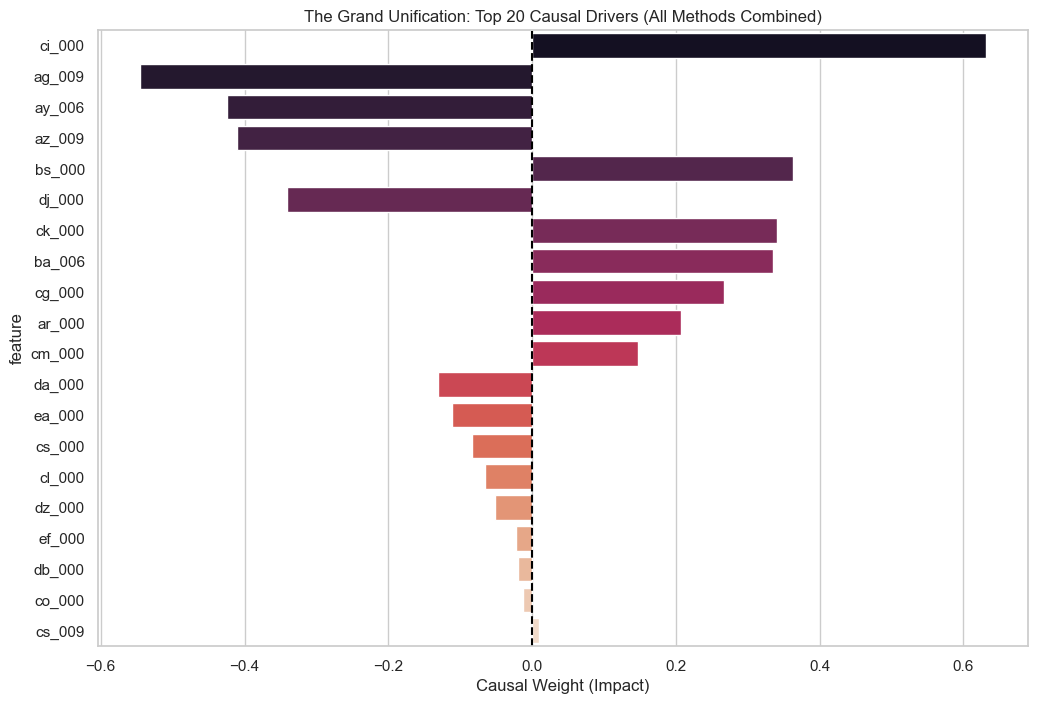

In [58]:
# --- 4. VISUALIZE THE VERDICT ---
print("\n--- The Final Verdict: True Causal Drivers ---")
summary_final = az.summary(trace_final, var_names=["weights"])
summary_final['feature'] = final_features
summary_final = summary_final.sort_values(by='mean', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=summary_final.head(20), x='mean', y='feature', palette='rocket')
plt.title("The Grand Unification: Top 20 Causal Drivers (All Methods Combined)")
plt.xlabel("Causal Weight (Impact)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

## 9. Visualizing the Causal Structure
We visualize the relationships between the Top Survivors and the Failure outcome using a **Causal Network Graph** and **SHAP Interaction Plots**.

In [59]:
# --- 1. PREPARE DATA FOR GRAPH ---
# Nodes: Top 15 Survivors + "Failure"
top_survivors = summary_final.head(12)['feature'].tolist()
summary_final_indexed = summary_final.set_index('feature')

nodes = top_survivors + ['Failure']


--- Building Causal Network Graph ---


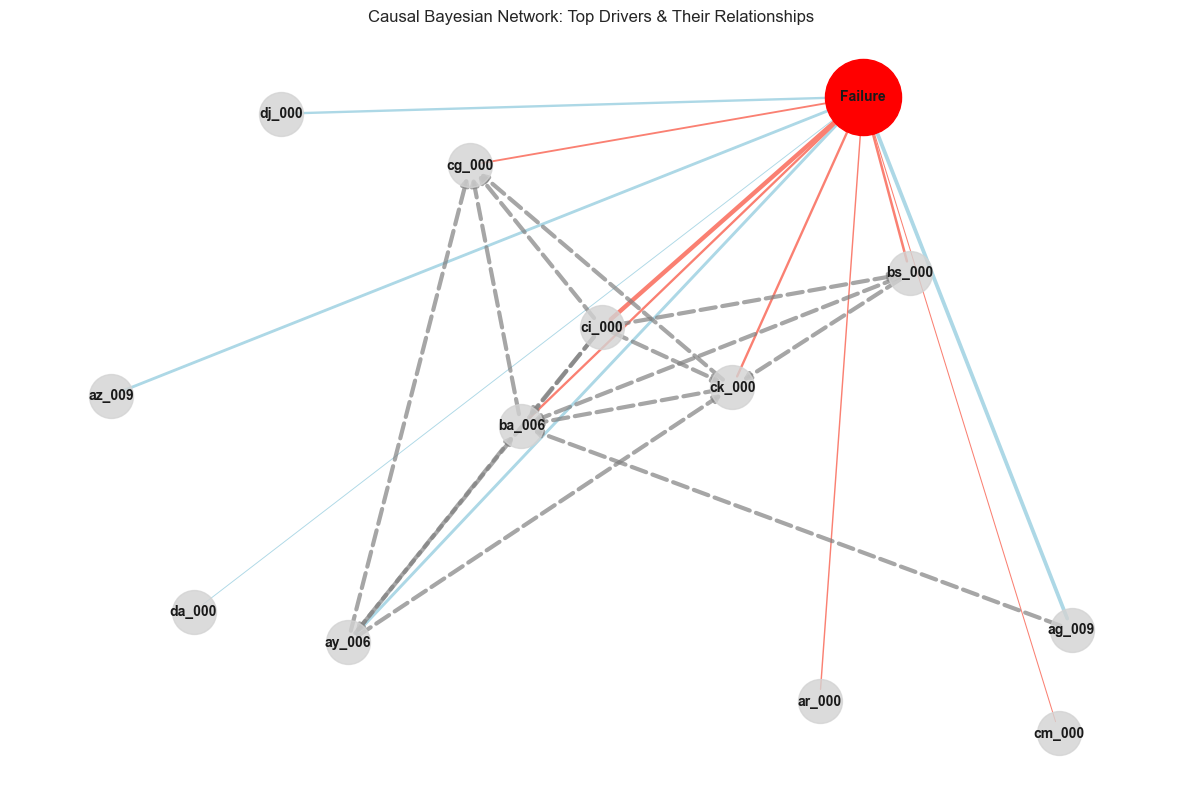


--- SHAP Interaction Analysis ---
Visualizing Interactions for: ['ck_000', 'bs_000', 'cb_000', 'aa_000']


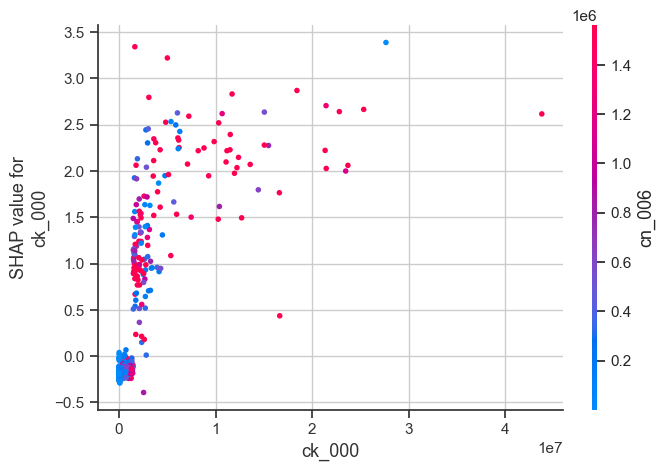

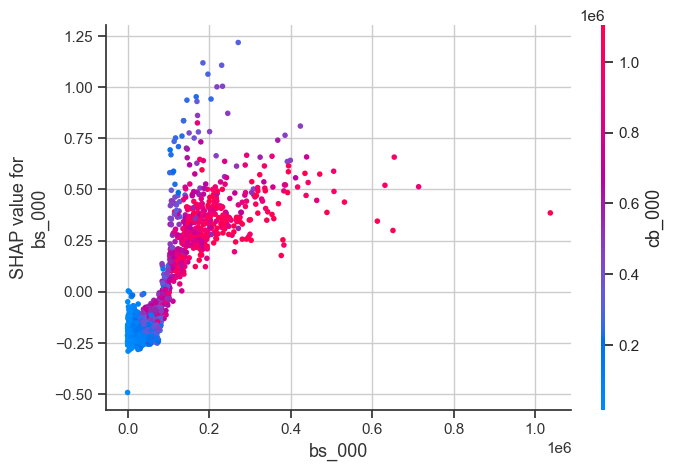

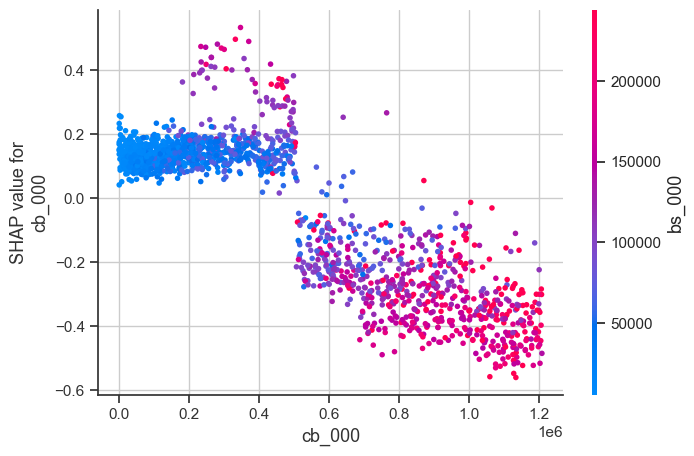

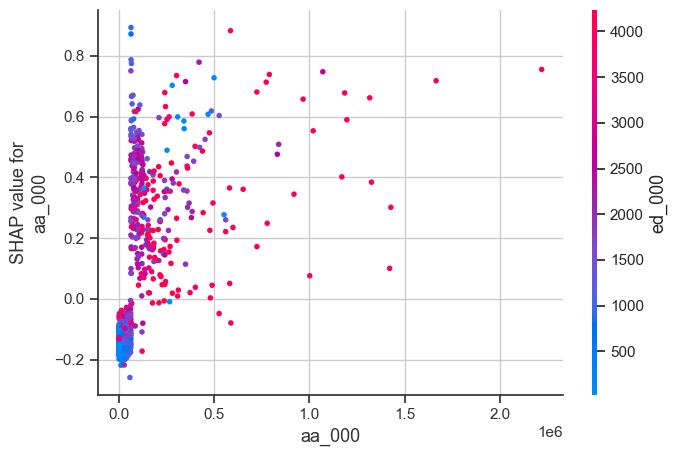

In [60]:
print("\n--- Building Causal Network Graph ---")

# Initialize Graph
G = nx.DiGraph()
G.add_nodes_from(nodes)

# Add Edges (Feature -> Failure)
edge_colors = []
edge_weights = []

for f in top_survivors:
    weight = summary_final_indexed.loc[f, 'mean']
    G.add_edge(f, 'Failure', weight=weight)
    
    # Color: Red for Positive (Risk), Blue for Negative (Protective)
    if weight > 0:
        edge_colors.append('salmon')
    else:
        edge_colors.append('lightblue')
    
    # Thickness: Proportional to absolute weight
    edge_weights.append(abs(weight) * 5)

# Add Edges (Feature <-> Feature) - Correlations
X_survivors = X_train_clean[top_survivors]
corr_surv = X_survivors.corr(method='spearman')
corr_edges = []
for i, f1 in enumerate(top_survivors):
    for f2 in top_survivors[i+1:]:
        c = corr_surv.loc[f1, f2]
        if abs(c) > 0.5: # Threshold
            G.add_edge(f1, f2, weight=c)
            corr_edges.append((f1, f2))

# --- 2. DRAW GRAPH ---
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42, k=0.9)

nx.draw_networkx_nodes(G, pos, nodelist=top_survivors, node_color='lightgray', node_size=1000, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=['Failure'], node_color='red', node_size=3000)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

causal_edges = [(u, v) for u, v in G.edges() if v == 'Failure']
nx.draw_networkx_edges(G, pos, edgelist=causal_edges, width=edge_weights, edge_color=edge_colors, arrowsize=20)
nx.draw_networkx_edges(G, pos, edgelist=corr_edges, width=3, edge_color='gray', style='dashed', alpha=0.7)

plt.title("Causal Bayesian Network: Top Drivers & Their Relationships")
plt.axis('off')
plt.show()

# --- 3. SHAP INTERACTION PLOTS ---
print("\n--- SHAP Interaction Analysis ---")
top_shap = shap_importance.head(4)['feature'].tolist()
print(f"Visualizing Interactions for: {top_shap}")

for f in top_shap:
    shap.dependence_plot(f, shap_vals_pos, X_shap_sample, interaction_index="auto")